Iteration 1
Control change: 0.5
Iteration 2
Control change: 0.0
Converged!


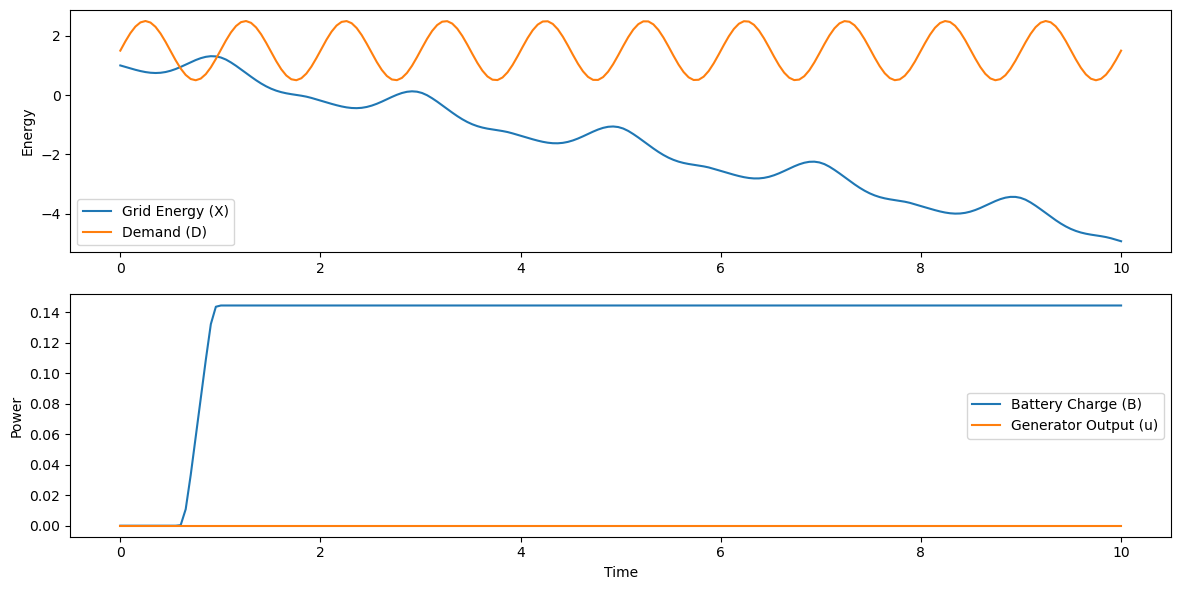

/tmp/ipykernel_74368/2462857987.py:35: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  totalsolar = np.vectorize(lambda t: quad(R, 0, t)[0])


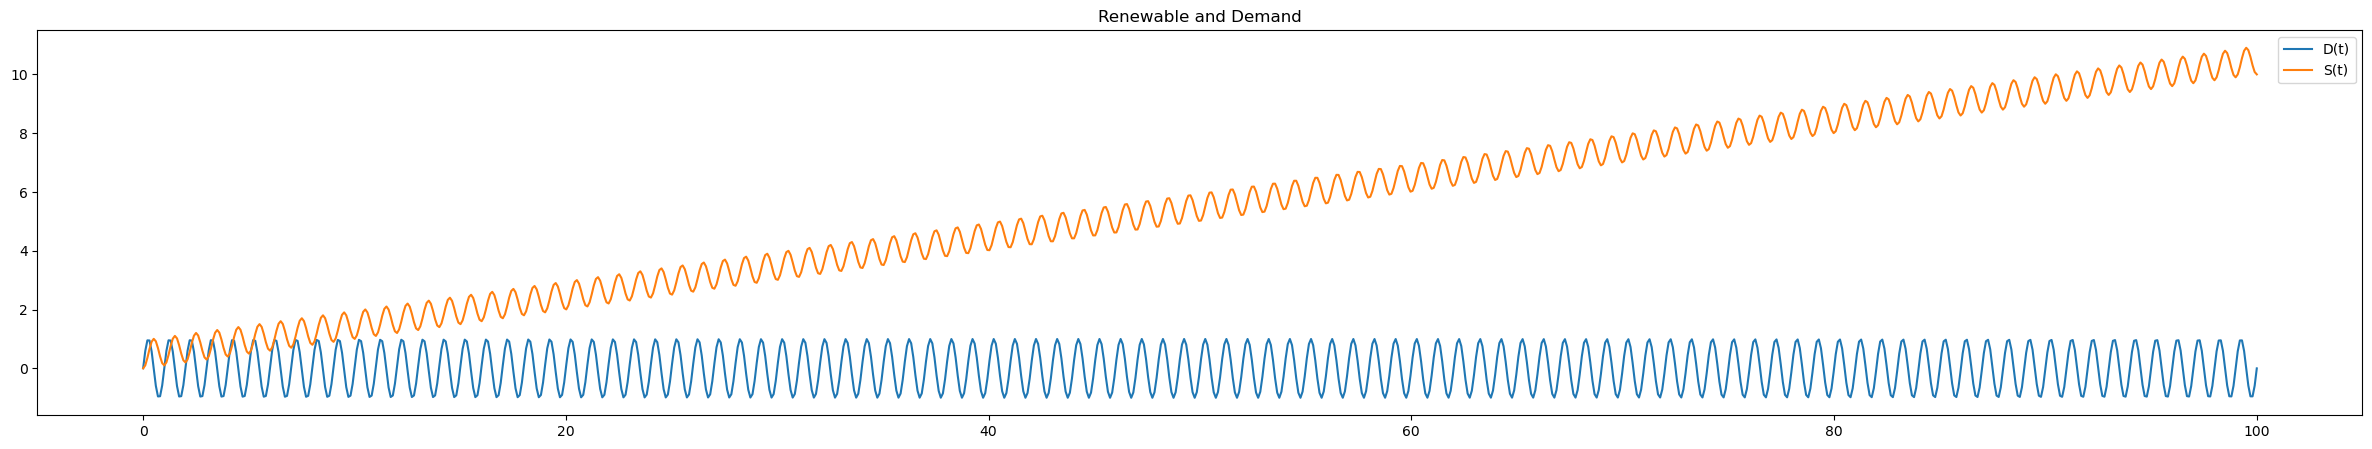

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline, interp1d
from matplotlib import pyplot as plt
from scipy.integrate import quad

Bmax = 1
D = lambda t: np.sin(2*np.pi*t) + t
Ddot = lambda t : 2 * np.pi * np.cos(2*np.pi*t)
R = lambda t:  np.sin(2*np.pi*t) + 0.1
C = 1

penalty = 2

def w(X, D):
    if X - D < 0:
        return -penalty * (X - D)
    if X - D - Bmax > 0:
        return penalty * (X - D - Bmax)
    return 0

def dwdX(X, D):
    if X - D < 0:
        return -penalty
    if X - D - Bmax > 0:
        return penalty
    return 0

t = np.linspace(0.001, 100, 1000)

plt.figure(figsize=(30, 5))
plt.title("Renewable and Demand")
plt.plot(t, D(t), label='D(t)')

totalsolar = np.vectorize(lambda t: quad(R, 0, t)[0])

plt.plot(t, totalsolar(t), label='S(t)')
plt.legend()
plt.show()

# X = np.linspace(-100, 100, 1000)
# B = np.linspace(-100, 100, 1000)


# plt.plot(X, np.vectorize(w1)(X), label='w1(X)')
# plt.show()

# plt.plot(B, np.vectorize(w2)(B), label='w2(B)')
# plt.show()

# xmesh, bmesh = np.meshgrid(X, B)
# plt.pcolormesh(xmesh, bmesh, np.vectorize(w3)(xmesh, bmesh, D(70)), shading='auto')
# plt.colorbar(label='w3(X, B)')
# plt.xlabel('X')
# plt.ylabel('B')
# plt.title('w3(X, B)')
# plt.show()






In [36]:
def state_equations(t, x, u_interp):
    X, B = x
    
    prod = R(t) + u_interp(t)
    return np.array([prod, prod - Ddot(t)])


def costate_equations(t, x):
    X, B = x
    # return np.array([dw1dX(X) + 0, dw2dB(B) + 0])
    return np.array([dwdX(X, D(t)), 0])
    

def optimal_control(p1, p2):
    return (p1 + p2) / (2*C)

t_f = 100
state0 = np.array([0, 0])

costate0 = np.array([0, 0])
t_eval = np.linspace(0, t_f, 1000)

u = 0.1*np.ones(len(t_eval))

max_step = 0.5

epsilon = 1e-6
test = epsilon + 1

maxiter = 100

iter = 0
while test > epsilon:
    iter += 1
    if iter > maxiter:
        print("Max iterations reached")
        break
    print("step1")
    u_old = u.copy()
    print(u_old.shape)
    u_interp = CubicSpline(t_eval, u_old)
    print("step2")

    state_sol = solve_ivp(state_equations, y0=state0, t_span=[0, t_f], t_eval=t_eval, args=(u_interp,), max_step=max_step,method='RK45')
    costate_sol = solve_ivp(costate_equations, y0=costate0, t_span=[t_f, 0], t_eval=t_eval[::-1], max_step=max_step,method='RK45')

    u = optimal_control(costate_sol.y[0], costate_sol.y[1])
    
    # Use clip instead of soft constraints?\
   

    test = abs(u - u_old).sum()

step1
(1000,)
step2
step1
(1000,)
step2


3.928773447456944e-15


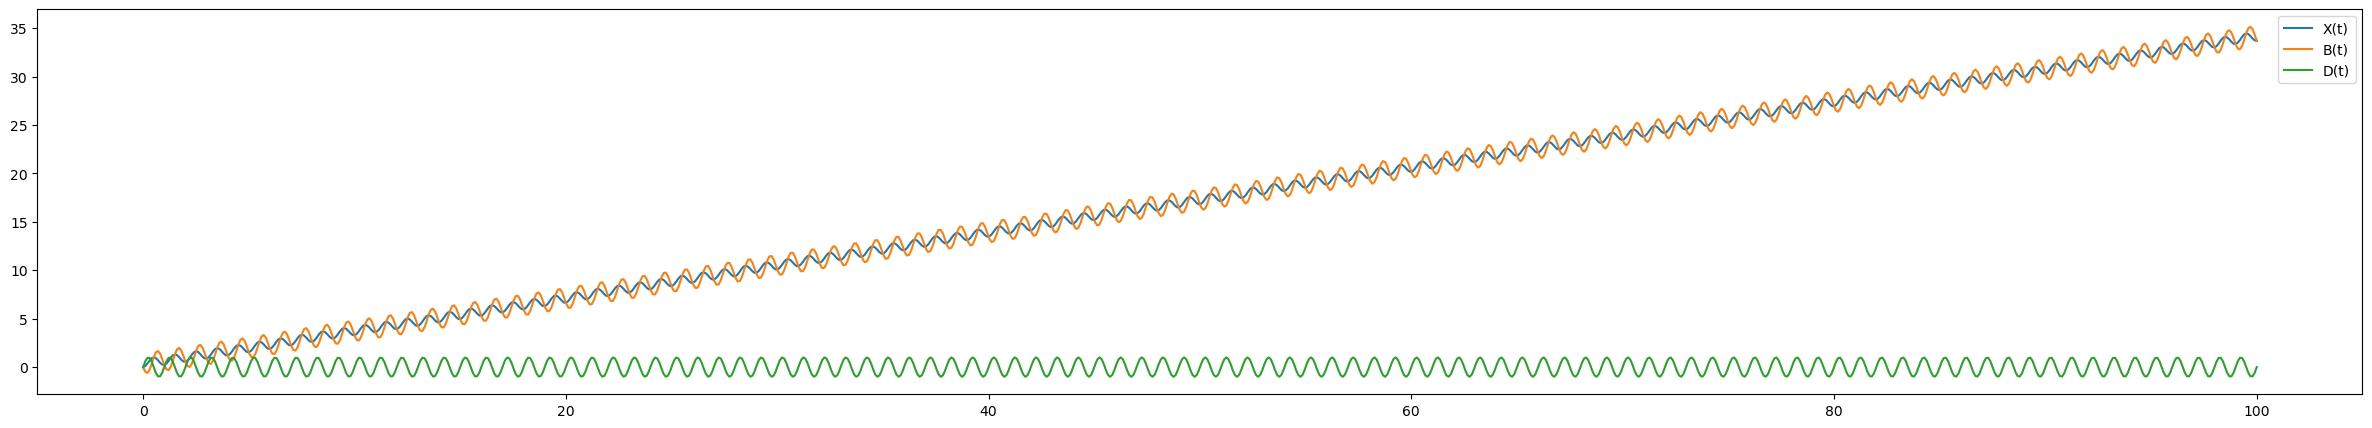

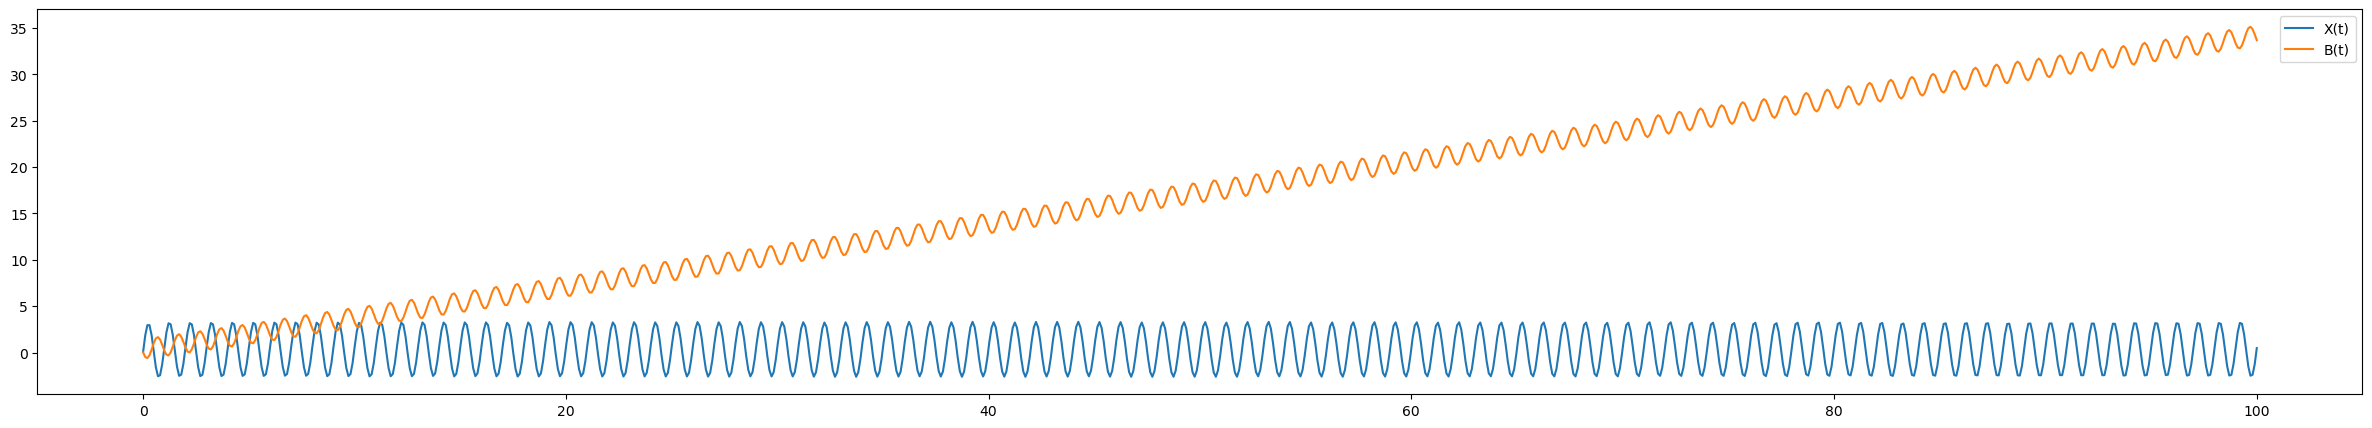

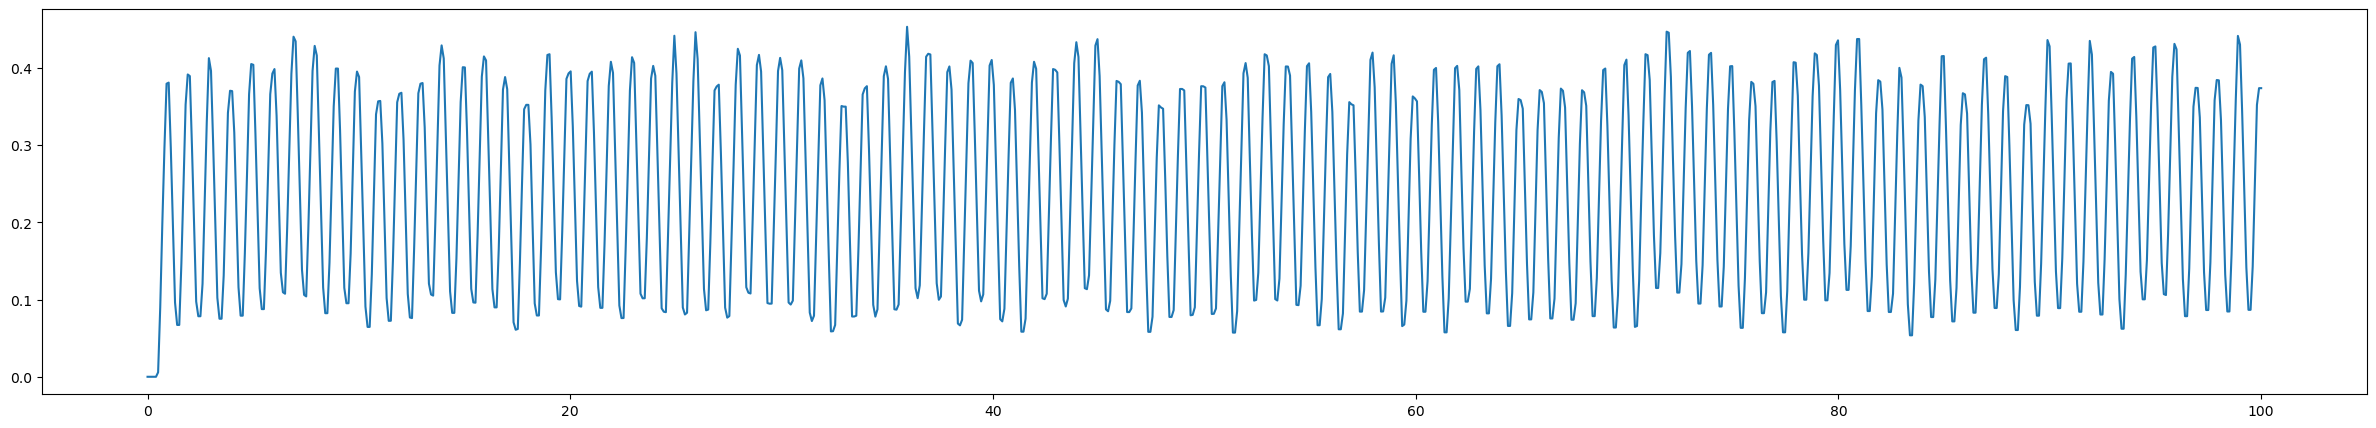

In [37]:
plt.figure(figsize=(30, 5))

plt.plot(t_eval, state_sol.y[0], label='X(t)')
plt.plot(t_eval, state_sol.y[1], label='B(t)')
plt.plot(t_eval, D(t_eval), label='D(t)')

print(D(t_eval[-1]))


plt.legend()
plt.show()


Xdot = R(t_eval) + u
Bdot = R(t_eval) + u - Ddot(t_eval)


plt.figure(figsize=(30, 5))
plt.plot(t_eval, Xdot, label='X(t)')
plt.plot(t_eval, state_sol.y[1], label='B(t)')

plt.legend()
plt.show()

plt.figure(figsize=(30, 5))
plt.plot(t_eval, u, label='u(t)')
plt.show()